# Teacher Student Network Research

##### Teacher Student Network Research
Framework adapted from Official Pytorch Knowledge Distillation Tutorial

Author:
Asad Amiruddin,
Harrison Maximillian Rush,
Huy N Ho

### Import library, datasets, loaders

In [59]:
%load_ext autoreload
%autoreload 2

!git clone https://github.com/pytorch/captum
%cd captum
!git checkout "v0.2.0"
!pip3 install -e .
import sys
sys.path.append('/content/captum')
%cd ..

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from time import time
from torchvision import models

from captum.attr import Saliency, IntegratedGradients, NoiseTunnel, DeepLift
from matplotlib import pyplot as plt
from captum.attr import visualization as viz
from torchvision import models

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataset_nonorm = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_nonorm)

# Dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader_nonorm = torch.utils.data.DataLoader(test_dataset_nonorm, batch_size=128, shuffle=False, num_workers=2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fatal: destination path 'captum' already exists and is not an empty directory.
/content/teacher-student-network/teacher-student-network/captum
HEAD is now at 4b2eb339 Adding matplotlib to Conda dependencies (#314)
Obtaining file:///content/teacher-student-network/teacher-student-network/captum
  Preparing metadata (setup.py) ... done
  Attempting uninstall: captum
    Found existing installation: captum 0.2.0
    Uninstalling captum-0.2.0:
      Successfully uninstalled captum-0.2.0
  Running setup.py develop for captum
/content/teacher-student-network/teacher-student-network
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Define functions

In [63]:
def train(model, train_loader, epochs, learning_rate, device):
    start = time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    end = time()
    runtime = end - start
    print(f"Training Time: {runtime:.3f}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    print('Knowledge distillation training')
    start = time()
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)


            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft target loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    end = time()
    runtime = end - start
    print(f"Training Time: {runtime:.3f}")

def show_saliency_map(model, data_loader,title, img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.to(device)
    model.eval()
    saliency = Saliency(model)
    gradients = saliency.attribute(input, target=labels[img_index].item())
    gradients = np.transpose(gradients.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(gradients, original_image, method="blended_heat_map", sign="absolute_value",
                              show_colorbar=True, title= title + " - Overlayed Gradient Magnitudes - " + img_label )
    return None

def show_integrated_grad(model, data_loader = test_loader,title = 'Teacher Model', img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.eval()
    ig = IntegratedGradients(model)

    model.zero_grad()
    ig = ig.attribute(input,target=labels[img_index])
    ig = np.transpose(ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(ig, original_image, method="blended_heat_map",sign="all",
                              show_colorbar=True, title="Overlayed Integrated Gradients - Image #" + img_label)
    return None

### Define deeper neural networks to be used as teachers.
Can have multiple teachers for comparison/experiments


### Load resnet50 model with finetuned weight as another teacher

In [46]:
teacher_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
teacher_resnet50.fc = nn.Linear(teacher_resnet50.fc.in_features, 10)
teacher_resnet50 = teacher_resnet50.to(device)
teacher_resnet50.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth",map_location=device  ))
# teacher_resnet50.load_state_dict(torch.load("./trained_model/teacher_resnet50.pth",map_location=device))
test_accuracy_teacher = test(teacher_resnet50, test_loader, device)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 95.67%


### Define student network


In [47]:
# Define the student model
class studentNN(nn.Module):
    def __init__(self):
        super(studentNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate the model
# studentNN = studentNN().to(device)

# test_accuracy_student = test(studentNN, test_loader, device)

### Instantiate the 2 identical student nets

In [48]:

# Instantiate the lightweight network:
# We instantiate one more lightweight network model to compare their performances.
# Back propagation is sensitive to weight initialization,
# so we need to make sure these two networks have the exact same initialization.
torch.manual_seed(42)
learning_student = studentNN().to(device)

torch.manual_seed(42)
non_learning_student = studentNN().to(device)

# To ensure we have created a copy of the first network, we inspect the norm of its first layer.
# If it matches, then we are safe to conclude that the networks are indeed the same.

# Print the total number of parameters in each model:
total_params_teacher = "{:,}".format(sum(p.numel() for p in teacher_resnet50.parameters()))
print(f"DeepNN parameters: {total_params_teacher}")
total_params_non_learning_student = "{:,}".format(sum(p.numel() for p in non_learning_student.parameters()))
print(f"non_learning_student parameters: {total_params_non_learning_student}")
total_params_learning_student = "{:,}".format(sum(p.numel() for p in learning_student.parameters()))
print(f"learning_student parameters: {total_params_learning_student}")

DeepNN parameters: 23,528,522
non_learning_student parameters: 51,479,114
learning_student parameters: 51,479,114


### Train the students and compare to the one without teacher

In [49]:


load_non_learning_student_model_from_Gdrive = True   # need to be on Colab
load_non_learning_student_model_from_local_hard_drive = False

if load_non_learning_student_model_from_Gdrive:
    non_learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth"  ))
elif load_non_learning_student_model_from_local_hard_drive :
    non_learning_student.load_state_dict(torch.load("./trained_model/non_learning_student.pth",map_location=device))
else:
    #train non_learning_student on train dataset
    train(non_learning_student, train_loader, epochs=10, learning_rate=0.001, device=device)


load_learning_student_model_from_Gdrive = True   # need to be on Colab
load_learning_student_model_from_local_hard_drive = False

if load_learning_student_model_from_Gdrive:
    learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/learning_student.pth"  ))
elif load_learning_student_model_from_local_hard_drive :
    learning_student.load_state_dict(torch.load("./trained_model/learning_student.pth",map_location=device))
else:
    # Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
    train_knowledge_distillation(teacher=teacher_resnet50, student=learning_student,
                                 train_loader=train_loader, epochs=10, learning_rate=0.001,
                                 T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)

test_accuracy_learning_student = test(learning_student, test_loader, device)
test_accuracy_non_learning = test(non_learning_student, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
# Result shouldn't be stellar because teacher's prediction can't beat ground truth here
print(f"Teacher accuracy: {test_accuracy_teacher:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_non_learning:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_learning_student:.2f}%")

Test Accuracy: 70.58%
Test Accuracy: 68.80%
Teacher accuracy: 95.67%
Student accuracy without teacher: 68.80%
Student accuracy with CE + KD: 70.58%


### Save trained models - only run after training on Colab

In [50]:
# IMPORTANT
# change the boolean below to True to save the trained model .pth file into your Google Drive
# only work if executing on Google Colab
save_model_to_Gdrive = False # need to be on Colab
save_model_to_local_drive = False
if save_model_to_Gdrive:
    torch.save(teacher_resnet50.state_dict(), "/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/learning_student.pth") # student after KD
elif save_model_to_local_drive:
    torch.save(teacher_resnet50.state_dict(), "./trained_model/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "./trained_model/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "./trained_model/learning_student.pth") # student after KD



### Model interpretation    

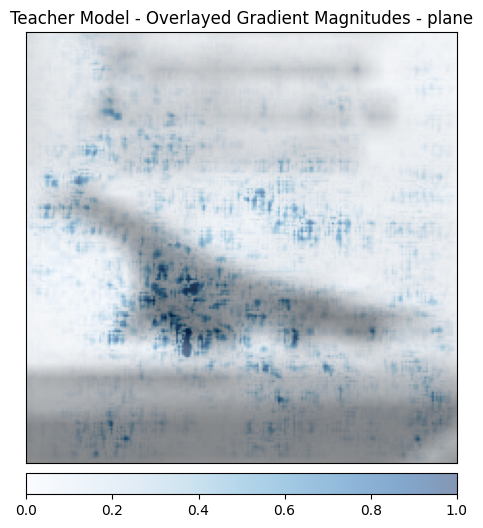

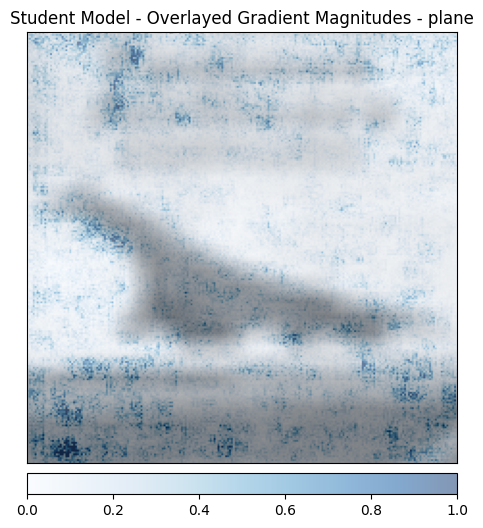

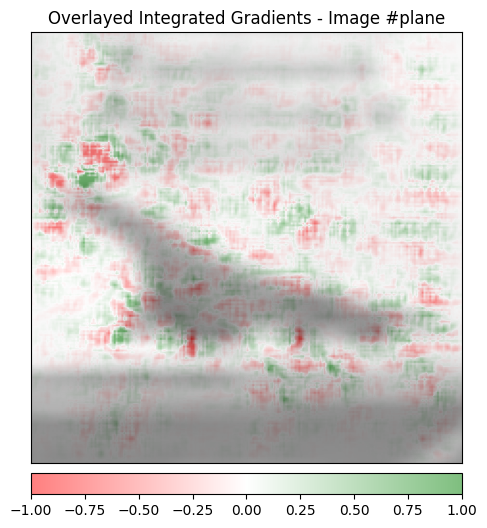

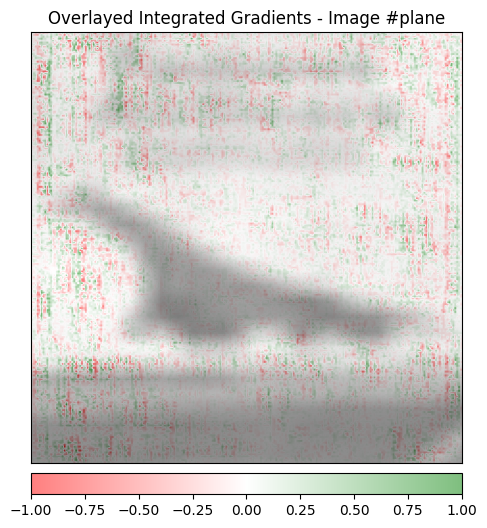

In [64]:
show_saliency_map(model = teacher_resnet50, data_loader = test_loader_nonorm,title = 'Teacher Model', img_index=3)
show_saliency_map(model = learning_student, data_loader = test_loader_nonorm,title = 'Student Model', img_index=3)
show_integrated_grad(model = teacher_resnet50, data_loader = test_loader_nonorm,title = 'Teacher Model', img_index=3)
show_integrated_grad(model = learning_student, data_loader = test_loader_nonorm,title = 'Student Model', img_index=3)

# Resnet and Intermediate Feature Transfer

Found a pretrained resnet32 on Cifar-10. 93% Accuracy reproduceable
https://github.com/chenyaofo/pytorch-cifar-models

![image.png](attachment:image.png)

In [ ]:
from helper import *

We set hooks to provide the activation outputs at the specified layers

In [ ]:
resnet32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet32", pretrained=True).to(device)
student_inter = studentNN(num_classes=10).to(device)

teacher_layer= resnet32.layer2[2]
teacher_activations = Hook(teacher_layer)

student_layer = student_inter.features[4]
student_activations = Hook(student_layer)

In [ ]:
test(resnet32, test_loader, device)
test(student_inter, test_loader, device)

Test Accuracy: 93.33%
Test Accuracy: 9.86%


9.86

In [ ]:
print(student_activations.output.shape)
print(teacher_activations.output.shape)
print(resnet32.layer2)
print(student_inter)

torch.Size([128, 16, 16, 16])
torch.Size([128, 32, 16, 16])
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

First stage training optimizes up to the hidden layer specified earlier, and uses the loss between teacher and student activations. Afterwards, we continue with the regular training routine

In [ ]:

train_first_stage(train_loader, student_inter, resnet32, hint_loss, 10, 0.001)
test(student_inter, test_loader, device)
train(student_inter, train_loader, epochs=10, learning_rate=0.001, device=device)
test(student_inter, test_loader, device)


Epoch 1/20, Loss: 0.05157574638724327
Epoch 2/20, Loss: 0.04706999287009239
Epoch 3/20, Loss: 0.04581158980727196
Epoch 4/20, Loss: 0.04574974253773689
Epoch 5/20, Loss: 0.04547273740172386
Epoch 6/20, Loss: 0.04224554821848869
Epoch 7/20, Loss: 0.04153849184513092
Epoch 8/20, Loss: 0.04186097905039787
Epoch 9/20, Loss: 0.04079979658126831
Epoch 10/20, Loss: 0.04044629633426666
Epoch 11/20, Loss: 0.04031776264309883
Epoch 12/20, Loss: 0.04033951088786125
Epoch 13/20, Loss: 0.04027434065937996
Epoch 14/20, Loss: 0.04041905701160431
Epoch 15/20, Loss: 0.04043997451663017
Epoch 16/20, Loss: 0.040389951318502426
Epoch 17/20, Loss: 0.04032289981842041
Epoch 18/20, Loss: 0.040344130247831345
Epoch 19/20, Loss: 0.040576037019491196
Epoch 20/20, Loss: 0.04046780616044998
First Stage Training Time: 89.32452321052551
Test Accuracy: 10.08%
Epoch 1/10, Loss: 1.3600120071864799
Epoch 2/10, Loss: 0.828291775320497
Epoch 3/10, Loss: 0.6808459966841256
Epoch 4/10, Loss: 0.6015299591414459
Epoch 5/10, 

72.02